In [17]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
from yellowbrick.features import RFECV
import warnings
warnings.filterwarnings('ignore') # for deprecated matplotlib functions

In [2]:
data = np.genfromtxt("spambase.data", delimiter=',')
X = data[:,:-1]
#X = data[:,:48]
Y = data[:,-1]
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#print(X)

In [3]:
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=1)

In [4]:
print("Number of features:\t", X.shape[1])
print("Number of training data points:\t", Xtr.shape[0])
print("Number of test data points:\t", Xte.shape[0])

Number of features:	 57
Number of training data points:	 3220
Number of test data points:	 1381


In [5]:
print(X.shape)

(4601, 57)


## Feature Selection - RFE

In [ ]:
def get_features (support):
    count = 0
    arr = []
    for i in support:
        if i:
            arr.append(count)
        count += 1
    return arr

In [ ]:
cnt = 0
train_scores = list()
test_scores = list()
for i in range(1,X.shape[1]+1):
    logreg = LogisticRegression(tol=1e-8, C=0.1, random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
    selector = RFE(logreg, i).fit(X, Y)
    features = get_features(selector.support_)
    Xrfe = X[:,features]
    Xrfe_tr, Xrfe_te, Yrfe_tr, Yrfe_te = train_test_split(Xrfe, Y, test_size=0.3, shuffle=True, random_state=1)
    clf = logreg.fit(Xrfe_tr,Yrfe_tr)
    train_score = clf.score(Xrfe_tr,Yrfe_tr)
    test_score = clf.score(Xrfe_te,Yrfe_te)
    '''
    print("features:\t",i)
    print("training score:\t", train_score)
    print("test score:\t", test_score)
    '''
    train_scores.append(train_score)
    test_scores.append(test_score)

In [ ]:
#plt.rcParams["figure.figsize"] = (15.0,8.0)
plt.semilogy(range(1,X.shape[1]+1), train_scores, label="training score")
plt.semilogy(range(1,X.shape[1]+1), test_scores, label="test score")
plt.xlabel('Features')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
res = sorted(enumerate(test_scores), key=lambda d:d[1])[-1]
print("At feature =", res[0]," test score at highest at:", res[1])

## RFECV

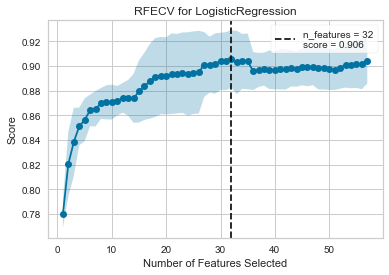

In [18]:
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=100000)
viz = RFECV(model)
viz.fit(X, Y)
viz.poof()

## Feature Selection - SelectFromModel

In [ ]:
logreg = LogisticRegression(tol=1e-8, C=0.1, random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000).fit(X, Y)
model = SelectFromModel(logreg, prefit=True)
X_new = model.transform(X)
Xtr, Xte, Ytr, Yte = train_test_split(X_new, Y, test_size=0.3, shuffle=True, random_state=1)

clf = LogisticRegression(tol=1e-8, C=0.1, random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000).fit(Xtr,Ytr)
print("features:\t",X_new.shape)
print("training score:\t", clf.score(Xtr,Ytr))
print("test score:\t", clf.score(Xte,Yte))

## Data Training

In [ ]:
#pca = PCA(n_components=30)
#Xpca = pca.fit_transform(X)
#print(Xpca)

In [ ]:
logreg = LogisticRegression(tol=1e-8, C=0.1, random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
clf = logreg.fit(Xtr,Ytr)
#clf  = LogisticRegression(tol=1e-8, C=10.0).fit(Xtr, Ytr)

In [ ]:
print("training score:\t", clf.score(Xtr,Ytr))
print("test score:\t", clf.score(Xte,Yte))

In [ ]:
Yhat = clf.predict(Xte)

In [ ]:
err = 0
for i in range(len(Xte)):
    if Yhat[i] != Yte[i]:
        err += 1
print("Error rate: ", err/len(Xte))

print("Ham Messages: ", len(np.where(Yte == 0)[0]))
print("Ham Prediction: ", len(np.where(Yhat == 0)[0]))
print("Spam Messages: ", len(np.where(Yte == 1)[0]))
print("Spam Prediction: ", len(np.where(Yhat == 1)[0]))

confusion_matrix(Yte, Yhat)

## Changing Parameters

In [ ]:
init = 10000
cval = []
train_error = []
test_error = []
for i in range(10):
    logreg = LogisticRegression(tol=1e-8, C=init, solver='lbfgs', multi_class='multinomial', max_iter=10000)
    clf = logreg.fit(Xtr,Ytr)
    train_error.append(1 - clf.score(Xtr,Ytr))
    test_error.append(1 - clf.score(Xte,Yte))
    cval.append(init)
    print("C=",init)
    print("training score:\t", clf.score(Xtr,Ytr))
    print("test score:\t", clf.score(Xte,Yte))
    init /= 10

In [ ]:
plt.rcParams["figure.figsize"] = (15.0,8.0)
plt.semilogy(range(10), train_error, label="training")
plt.semilogy(range(10), test_error, label="test")
#plt.xticks(cval)
plt.legend()
plt.show()

## Adding Polynomial Features

In [ ]:
poly = PolynomialFeatures(2).fit(Xtr)
XtrP = poly.transform(Xtr)

#scaler = StandardScaler().fit(XtrP, Ytr)
#XtrP = scaler.transform(XtrP)

XteP = poly.transform(Xte)

lrP = LogisticRegression(tol=1e-10, C=100, random_state=0, solver='lbfgs', multi_class='multinomial')
clf = lrP.fit(XtrP,Ytr)

print("training score:\t", clf.score(XtrP,Ytr))
print("test score:\t", clf.score(XteP,Yte))

## Visualizations

In [11]:
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=100000)

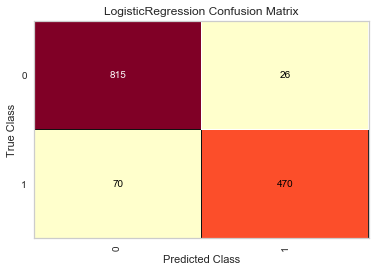

In [12]:
cm = ConfusionMatrix(model, classes=[0, 1])
cm.fit(Xtr, Ytr)
cm.score(Xte, Yte)
cm.poof()

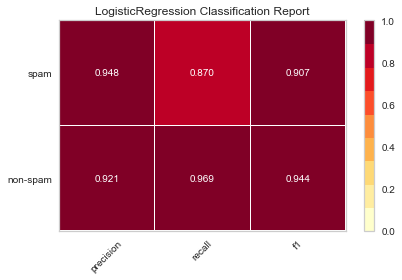

In [13]:
visualizer = ClassificationReport(model, classes=['non-spam', 'spam'])

visualizer.fit(Xtr, Ytr)
visualizer.score(Xte, Yte)
visualizer.poof()

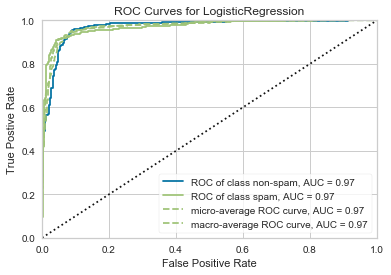

In [14]:
visualizer = ROCAUC(model, classes=['non-spam', 'spam'])
visualizer.fit(Xtr, Ytr)
visualizer.score(Xte, Yte)
visualizer.poof()